<a href="https://colab.research.google.com/github/menon92/DL-Sneak-Peek/blob/master/data_drift_detection_on_cifar10_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q alibi-detect

     |████████████████████████████████| 329 kB 4.2 MB/s 
     |████████████████████████████████| 4.8 MB 46.3 MB/s 
     |████████████████████████████████| 3.8 MB 32.8 MB/s 
     |████████████████████████████████| 462 kB 46.9 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 895 kB 48.3 MB/s 
     |████████████████████████████████| 596 kB 49.9 MB/s 
     |████████████████████████████████| 6.6 MB 34.0 MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from alibi_detect.cd import KSDrift
from alibi_detect.ad import ModelDistillation

from alibi_detect.models.tensorflow.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model, fetch_detector
from alibi_detect.utils.tensorflow.prediction import predict_batch
from alibi_detect.utils.saving import save_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c

# source: https://docs.seldon.io/projects/alibi-detect/en/latest/examples/cd_distillation_cifar10.html#Dataset

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_train = scale_by_instance(X_train)
y_train = y_train.astype('int64').reshape(-1,)
X_test = X_test.astype('float32') / 255
y_test = y_test.astype('int64').reshape(-1,)

170508288/170498071 [==============================] - 11s 0us/step


In [4]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


In [5]:
corruption = ['gaussian_noise', 'motion_blur', 'brightness', 'pixelate']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=5, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

In [6]:
X_c = []
n_corr = len(corruption)
n_test = X_test.shape[0]
for i in range(n_corr):
    X_c.append(X_corr[i * n_test:(i + 1) * n_test])

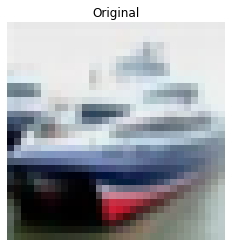

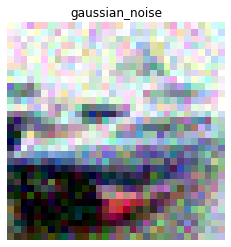

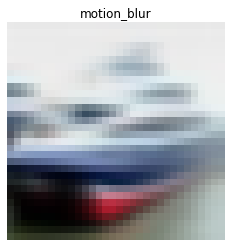

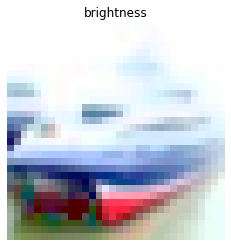

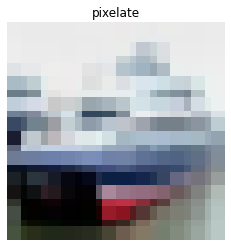

In [7]:
i = 1

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

In [8]:
dataset = 'cifar10'
model = 'resnet32'
clf = fetch_tf_model(dataset, model)
acc = clf.evaluate(scale_by_instance(X_test), y_test, batch_size=128, verbose=0)[1]
print('Test set accuracy:')
print('Original {:.4f}'.format(acc))
clf_accuracy = {'original': acc}
for _ in range(len(corruption)):
    acc = clf.evaluate(scale_by_instance(X_c[_]), y_test, batch_size=128, verbose=0)[1]
    clf_accuracy[corruption[_]] = acc
    print('{} {:.4f}'.format(corruption[_], acc))

4308992/4293464 [==============================] - 0s 0us/step
Test set accuracy:
Original 0.9278
gaussian_noise 0.2208
motion_blur 0.6339
brightness 0.8913
pixelate 0.3666
